# EVALUACIÓN DE APTITUD TERRITORIAL PARA IDENTIFICACIÓN DE ZONAS DE EXPANSIÓN URBANA PARA MUNICIPIOS INTERMEDIOS

**OBJETIVO PROYECTO**


Identificar áreas potenciales de expansión urbana considerando criterios demográficos, ambientales, físicos y de accesibilidad, a través de herramientas de análisis espacial.

# 2. Notebook Análisis espacial

**Proyecto Final Programación SIG**

**Maestria en Geomática**

Estudiantes: 
* Sara Alarcon Prieto
* Gizela Guzmán Lugo
  

Fecha: 18/07/2025

## 2.1 INTRODUCCIÓN

Este notebook desarrolla un análisis espacial para identificar áreas aptas para expansión urbana utilizando datos del municipio de interes especificados en el notebook #1 data_preparation usando criterios como:
* Pendiente del terreno menor al 15%
* Cercania a vias principales (< 1 km)
* Cercania a centros poblados (< 1 km)
* Restricción con faja de protección hidrica ( > 30 m)
* No ubicadas en bosques y zonas de protección
* Coberturas de la tierra compatible con expansión urbana (Pastizales, áreas agricolas)
* Evitar zonas inestables por movimientos en masa


El objetivo es visualizar zonas prioritarias mediante un índice ponderado de idoneidad.


## 2.2 ANALISIS DE DATOS 
### 2.2.1 Importación de librerias
Se importan las bibliotecas necesarias para análisis espacial, visualización y manejo de datos.

In [1]:
# Importación de bibliotecas
import geopandas as gpd       # Para trabajar con datos espaciales tipo shapefile
import pandas as pd           # Manejo de tablas tipo DataFrame
import matplotlib.pyplot as plt  # Visualización de gráficos
import contextily as ctx      # Agregar mapas base
from matplotlib.colors import ListedColormap  # Crear mapas de colores personalizados
import matplotlib.patches as mpatches         # Crear leyendas personalizadas
import os # Permite interactuar con el sistema operativo
import sys ## Módulo que permite manipular el sistema
sys.path.append('../src')  # subir un nivel de carpeta y entrar a src(carpeta con funciones)

import analysis_functions # Módulo que contiene funciones de análisis 
from analysis_functions import unir_gdfs  # Función para unir capas
from analysis_functions import grilla_expansion_urbana # función para generar grilla

### 2.2.2 Carga de capas geográficas: Zonas no aptas
Este bloque de código tiene como finalidad cargar diferentes capas geográficas en formato .feather que representan zonas no aptas para la expansión urbana. Estas capas corresponden a criterios de restricción como centros poblados, amenazas naturales, coberturas de bosques y pastos, zonas de protección de suelos, pendientes elevadas, y límites municipales. Se utilizarán posteriormente para análisis espaciales.
Cada capa es cargada como un GeoDataFrame mediante la librería geopandas (gpd).

In [2]:
# Zonas no aptas
# Carga la capa de centros poblados para identificar áreas urbanizadas existentes
centros_pob_clip = gpd.read_feather('centrospob.feather')  
# Carga la capa de amenazas naturales (alta amenaza) para excluir zonas de riesgo
Amenaza_alta = gpd.read_feather('amenaza_temporal.feather')  
# Carga la capa de cobertura de bosques que actúa como restricción ambiental
Bosques = gpd.read_feather('bosques_temporal.feather')  
# Carga las zonas definidas como protección del suelo (zonas ambientales restringidas)
Suelo_Proteccion = gpd.read_feather('sueloprot_temporal.feather')  
# Carga los buffers de rondas hídricas (zonas de protección alrededor de cuerpos de agua)
buffers_rondaH = gpd.read_feather('buffers_ronda_temporal.feather')  
# Carga la capa de límites municipales para restringir el análisis al municipio de estudio
municipio = gpd.read_feather('municipio.feather')  
# Carga la capa de pastos, que son tratados como cobertura restringida
Pastos = gpd.read_feather('pastos_temporal.feather')  
# Carga la clasificación de pendiente, para identificar áreas con pendientes elevadas
clas_pend = gpd.read_feather('clas_pend.feather') 

#Rutas de salida
output_folder_maps = r"/notebooks/PROYECTO_FINAL/results/maps"

### 2.2.3 Unión de GeoDataFrames para zonas no aptas

Este código tiene como finalidad unificar múltiples capas geográficas (representadas como GeoDataFrames) en un único conjunto de datos, agregando una columna opcional que identifica el origen de cada registro. Además, permite reproyectar todas las capas a un mismo sistema de referencia espacial (CRS) si es necesario.

Esta operación es clave para consolidar diferentes criterios de restricción espacial en un único conjunto de datos que facilite el análisis conjunto de las zonas no aptas. Lo cual se logra mediante la función creada unir_gdfs.

Se unieron capas con restricciones como:
* Centros poblados
* Zonas de amenaza alta
* Áreas boscosas
* Suelos de protección
* Rondas hídricas (buffers alrededor de cuerpos de agua)


In [3]:
# Crear lista con las capas que representan restricciones espaciales
lista_gdfs = [
    centros_pob_clip,    # Centros poblados
    Amenaza_alta,        # Amenaza alta
    Bosques,             # Bosques
    Suelo_Proteccion,    # Suelo protegido
    buffers_rondaH       # Rondas hídricas
]

# Definir nombres identificadores de cada capa
nombres = [
    "centros_pob_clip",
    "Amenaza_alta",
    "Bosques",
    "Suelo_Proteccion",
    "buffers_rondaH"
]

# Ejecutar función para unir capas reproyectando a EPSG:9377
Zonas_noaptas = unir_gdfs(
    lista_gdfs=lista_gdfs,   # Lista de capas
    nombres=nombres,         # Nombres identificadores
    crs_objetivo=9377        # Reproyección al CRS EPSG:9377
)

# Visualizar primeras filas del resultado
print(Zonas_noaptas[['origen', 'geometry']].head())


             origen                                           geometry
0  centros_pob_clip  POLYGON ((4896009.041 2103904.164, 4896017.521...
1  centros_pob_clip  POLYGON ((4894290.448 2104144.675, 4894296.553...
2  centros_pob_clip  POLYGON ((4895060.364 2104345.18, 4895069.987 ...
3  centros_pob_clip  POLYGON ((4892986.214 2104357.647, 4892989.257...
4  centros_pob_clip  POLYGON ((4894850.366 2104869.258, 4894858.721...


## 2.3 VISUALIZACIÓN DATOS

En esta sección se presentan los mapas de zonas no aptas por capa de origen y el mapa de clases de pendiente vectorizado, los cuales cumplen un papel fundamental en el proceso de creación del índice de idoneidad para zonas de expansión urbana. Estas visualizaciones permiten identificar de manera clara las áreas restringidas o limitadas según cada criterio temático, así como las pendientes del terreno, facilitando la toma de decisiones al momento de definir posibles zonas de expansión de manera técnica y argumentada.

### 2.3.1 Mapa zonas no aptas por capa de origen 

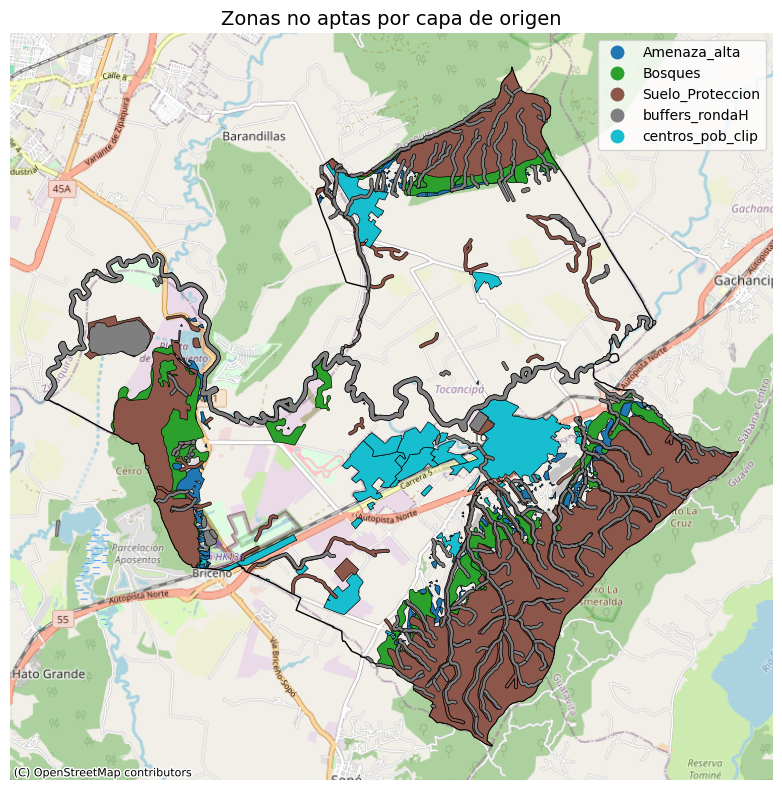

In [4]:
# Reproyectar a EPSG:3857 si es necesario
if municipio.crs.to_epsg() != 3857:
    municipio = municipio.to_crs(epsg=3857)

if Zonas_noaptas.crs.to_epsg() != 3857:
    Zonas_noaptas = Zonas_noaptas.to_crs(epsg=3857)

# Crear figura y eje
fig, ax = plt.subplots(figsize=(10, 8))

# Dibujar el municipio como fondo
municipio.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Dibujar las zonas no aptas por capa de origen
Zonas_noaptas.plot(
    ax=ax,
    column="origen",
    legend=True,
    cmap="tab10",
    edgecolor="black",
    linewidth=0.5
)

# Agregar mapa base de OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=Zonas_noaptas.crs)

# Ajustes del gráfico
plt.title("Zonas no aptas por capa de origen", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

# Guardar el mapa generado 
fig.savefig(
    os.path.join(output_folder_maps, "Zonas_no_aptas.png"),
    dpi=300,
    bbox_inches='tight'
)

#### 2.3.1.1 Conclusiones del Mapa: Zonas No Aptas por Capa de Origen
- El municipio presenta múltiples zonas no aptas para expansión urbana, las cuales fueron identificadas a partir de diferentes restricciones espaciales.
- Cada color en el mapa representa una capa de restricción distinta, lo cual fue posible gracias al código que unió todas las capas y las etiquetó según su origen.
- Las principales restricciones observadas en el mapa son:
1. Áreas de bosques (color verde) cubren gran parte del territorio, indicando limitaciones ambientales importantes.
2. Rondas hídricas (color gris) rodean cuerpos de agua y cursos fluviales, delimitando zonas protegidas.
3. Zonas cercanas a los centros poblados (color celeste) también se consideran no aptas, reflejando áreas ya urbanizadas.
4. Zonas de amenaza alta (color azul oscuro) refuerzan la exclusión de áreas con riesgos naturales.
5. Suelos de protección (color cafe) representan áreas con restricciones legales y funcionales para la expansión urbana.

### 2.3.2 Mapa de clases de pendiente vectorizada 

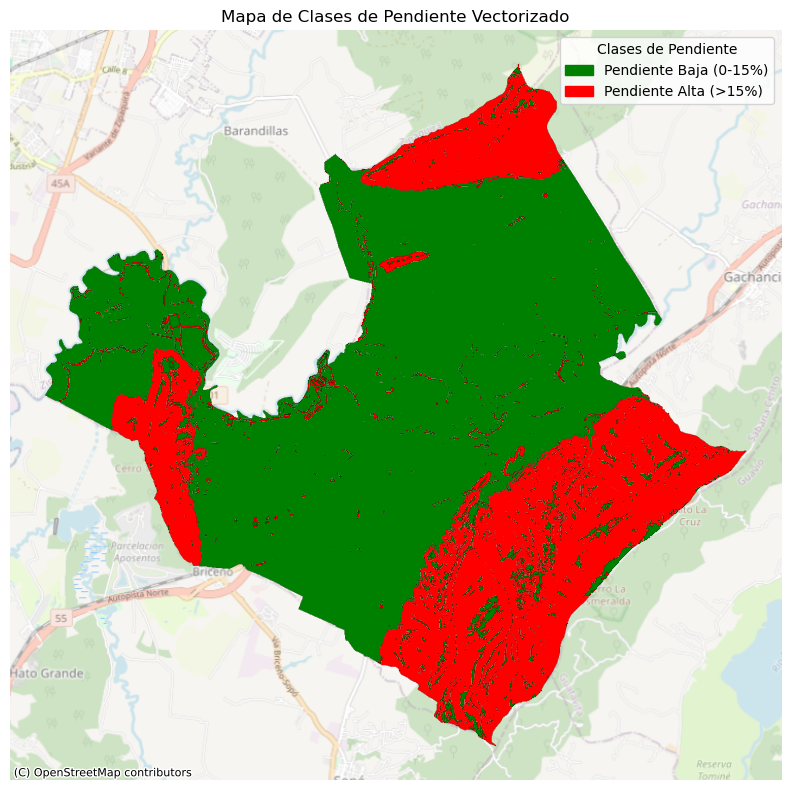

In [5]:
#Visualizacion mapa de pendientes por clase

# Define un diccionario que asigna colores a cada clase de pendiente:
colores = {
    1: 'green',  # Pendiente baja
    2: 'red',    # Pendiente alta
}

# Crea columna de color en el GeoDataFrame
clas_pend['color'] = clas_pend['slope_class'].map(colores)

# Crea figura
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Grafica GDF
clas_pend.plot(color=clas_pend['color'], edgecolor='black', linewidth=0.1, ax=ax)

# Agrega mapa base de OpenStreetMap
ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    crs=clas_pend.crs.to_string(),  # Asegura el CRS correcto del GDF
    alpha=0.6                        # Transparencia para ver colores de pendiente
)

# Crea leyenda manual
leyenda = [
    mpatches.Patch(color='green', label='Pendiente Baja (0-15%)'),
    mpatches.Patch(color='red', label='Pendiente Alta (>15%)')
]

# Añade la leyenda al mapa en la esquina superior derecha
plt.legend(handles=leyenda, loc='upper right', title='Clases de Pendiente')

# Títulos y estilo
ax.set_title("Mapa de Clases de Pendiente Vectorizado")
ax.axis('off')
plt.tight_layout()

# Mostrar
plt.show()

#### 2.3.2.1 Conclusión del mapa: clases de pendiente vectorizada
* Zonas Verdes (Pendiente Baja):
Representan áreas con pendientes suaves (0-15%), ideales para actividades como expansión urbana, agricultura o infraestructura, ya que presentan menores riesgos de erosión y son más accesibles.
* Zonas Rojas (Pendiente Alta):
Corresponden a terrenos con pendientes pronunciadas (>15%), que implican mayores riesgos de deslizamientos, erosión y dificultades para la construcción.
Ejemplo: Posibles áreas montañosas o colindantes con quebradas, donde la pendiente alta limita el uso urbanístico.

## 2.4 NORMALIZACIÓN DE CRITERIOS CONTINUIDAD URBANA 
Para realizar la normalizacion y poder llegar al indice de idoneidad se tiene en cuenta los cinco siguientes criterios: 
- Cercanía a centros poblados (más cerca = más apto).
- Cercanía a vías principales (más cerca = más apto).
- Densidad vial (mayor densidad = más apto).
- Pendiente ≤ 15° (menor pendiente = más apto).
- Cobertura agrícola - solo pastos (pastos = aptos).

### 2.4.1 Cargue de datos vectoriales y rutas

#### 2.4.1.1 Rutas

In [6]:
Ruta_Carpeta=r"/notebooks/PROYECTO_FINAL/Datos"
Municipio_interes = Ruta_Carpeta+'/TOCANCIPA.shp'
Centros_poblados = Ruta_Carpeta+'/Centros_Poblados_Cundinamarca.shp'
vias_vias = Ruta_Carpeta+'/via.shp'
vias_lvias = Ruta_Carpeta+'/limite_via.shp'

#### 2.4.1.2 Datos vectoriales

In [7]:
municipio = gpd.read_file(Municipio_interes).to_crs(epsg=9377)
Centros_pob = gpd.read_file(Centros_poblados).to_crs(epsg=9377)
vias_vias = gpd.read_file(vias_vias).to_crs(epsg=9377)
vias_lvias = gpd.read_file(vias_lvias).to_crs(epsg=9377)

#### 2.4.1.3 Cálculo de densidad víal
* Densidad víal: 
Este código busca calcular la densidad vial del municipio para poder normalizarlo y graficarlo, es uno de los criterios seleccionados.

In [8]:
# area del municipio 
area_municipio = municipio.geometry.area.iloc[0]
# Suma total de longitud de vías
longitud_total_vias = vias_vias['SHAPE_Leng'].sum()
longitud_total_lvias = vias_lvias['SHAPE_Leng'].sum()
# Densidad vial
longitud_total = longitud_total_vias+longitud_total_lvias
densidad_vial = (longitud_total / area_municipio) * 1e6  # m/km²
print(f"Densidad vial: {densidad_vial:.2f} m/km²")

Densidad vial: 5114.51 m/km²


#### 2.4.1.4 Corte de grilla a densidad víal

In [9]:
# Generar la grilla sobre el municipio
grid = grilla_expansion_urbana(municipio, cell_size=1000)

# Clip de la grilla al municipio (opcional, para no salirte)
grid= gpd.overlay(grid, municipio, how="intersection")

# Clip de las vías a la grilla
vias_todas = gpd.GeoDataFrame(
    pd.concat([vias_vias, vias_lvias], ignore_index=True),
    crs=vias_vias.crs
)
# Intersección de las vías con la grilla
vias_clip = gpd.overlay(vias_todas, grid, how="intersection")

# Asociar cada pedazo de vía a la celda correspondiente
vias_clip["longitud"] = vias_clip.geometry.length

# Agrupar por celda para sumar la longitud total de vías dentro de cada celda
# para eso necesitamos un id de celda
grid["id_celda"] = grid.index
vias_clip = gpd.sjoin(vias_clip, grid[["geometry", "id_celda"]], how="left", predicate="within")

longitudes_por_celda = vias_clip.groupby("id_celda")["longitud"].sum()
# Asociar a ese grilla
grid["longitud_vias"] = grid["id_celda"].map(longitudes_por_celda).fillna(0)

# Calcular densidad vial
grid["area"] = grid.geometry.area
grid["densidad_vial"] = (grid["longitud_vias"] / grid["area"]) * 1e6  # m/km²

#### 2.4.1.5 Normalización de la densidad víal
La finalidad de este código es visualizar en un mapa la densidad vial normalizada (valores entre 0 y 1) del municipio de interés, usando colores para representar las zonas con mayor o menor densidad de vías.

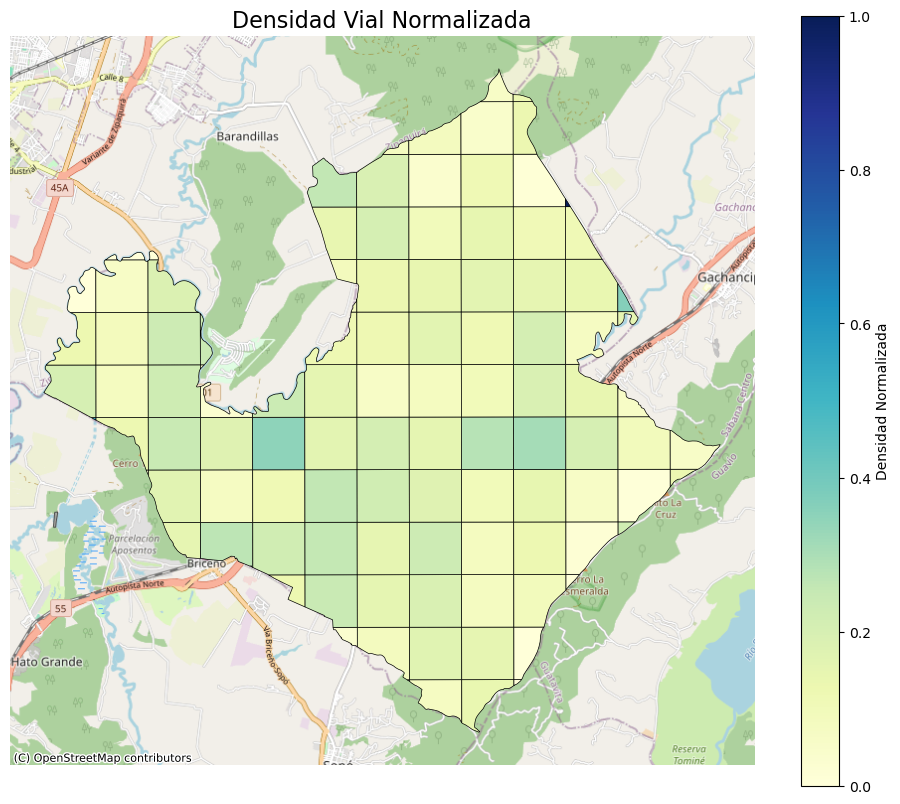

In [10]:
# Normalizar densidad del cero al 1
max_densidad = grid["densidad_vial"].max()
grid["densidad_norm"] = grid["densidad_vial"] / max_densidad

#mapa 
grid_webmercator = grid.to_crs(epsg=3857)

ax = grid_webmercator.plot(
    column="densidad_norm",
    cmap="YlGnBu",
    legend=True,
    legend_kwds={'label': "Densidad Normalizada"},
    figsize=(12, 10),
    edgecolor="black",
    linewidth=0.5
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Densidad Vial Normalizada", fontsize=16)

ax.axis('off')

plt.show()

# Guardar el mapa generado 
fig = ax.get_figure()
fig.savefig(
    os.path.join(output_folder_maps, "Normalización_Densidad_Vial.png"),
    dpi=300,
    bbox_inches='tight'
)

#### 2.4.1.6 Normalización cercanía a centros poblados
* Calcula el centroide de cada celda de la grilla, esto sirve para medir la distancia desde el centro de la celda hasta el punto más cercano de los centros poblados.

In [11]:
grid['centroide'] = grid.geometry.centroid

* Se calcula la distancia a los centros poblados

In [12]:
# Debemos tener lso centroides de los centros poblados y asi se recorre cada celda y obtiene la distancia mínima al centro poblado más cercano.
grid['distancia_centro_poblado'] = grid['centroide'].apply(
    lambda punto: Centros_pob.distance(punto).min()
)

* Se normaliza la distancia: se utiliza la formula 1 - (distancia / max) para que los valores cercanos a los centros poblados tiendan a 1 (más cercanía) y los más lejanos tiendan a 0

In [13]:
#Calculo distancia maxima
max_distancia = grid['distancia_centro_poblado'].max()
#Normalización
grid['distancia_centro_norm'] = 1 - (grid['distancia_centro_poblado'] / max_distancia)

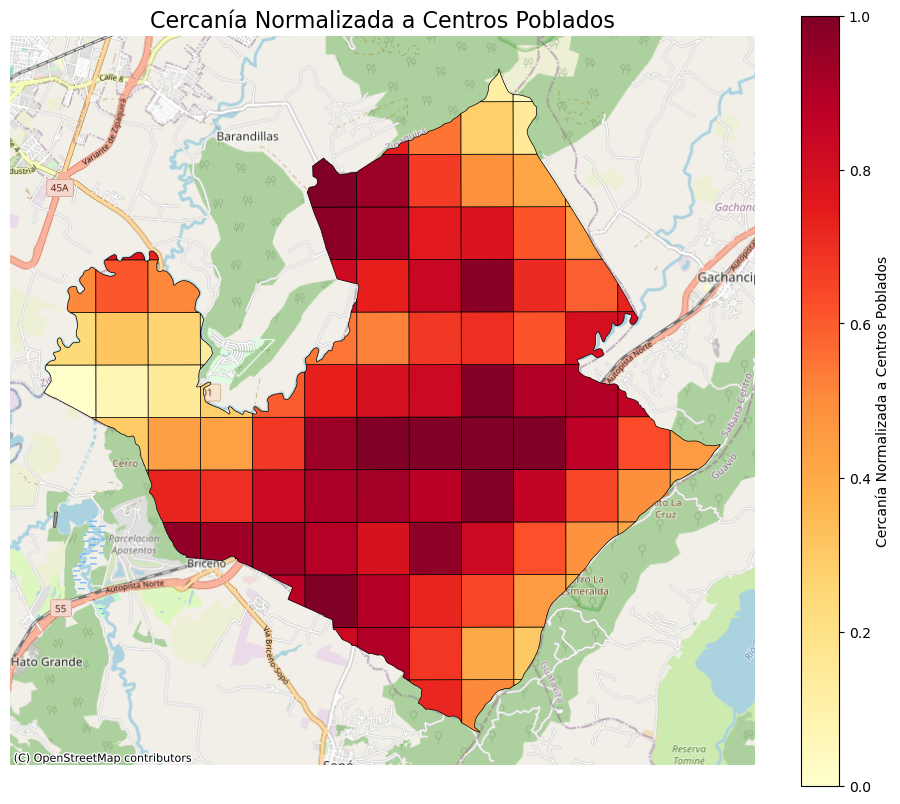

In [14]:
# Reproyectar para mapa base
grid_webmercator = grid.to_crs(epsg=3857)

ax = grid_webmercator.plot(
    column='distancia_centro_norm',
    cmap='YlOrRd',
    legend=True,
    legend_kwds={'label': "Cercanía Normalizada a Centros Poblados"},
    figsize=(12, 10),
    edgecolor='black',
    linewidth=0.5
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Cercanía Normalizada a Centros Poblados", fontsize=16)
ax.axis('off')
plt.show()

# Guardar el mapa generado 
fig = ax.get_figure()
fig.savefig(
    os.path.join(output_folder_maps, "Normalización_Cercania_centros_poblados.png"),
    dpi=300,
    bbox_inches='tight'
)


#### 2.4.1.7 Normalización cercania a vías

* para la normalizacion de cercania a vias se utiliza la union de vias_vias con vias_viasl (vias_total). Teniendo el centroide de las grillas calculamos la distancia mínima desde cada celda a las vías.

In [15]:
#cálculo distancia mínima
grid['distancia_vias'] = grid['centroide'].apply(
    lambda punto: vias_todas.distance(punto).min()
)

* Normalizamos las distancias de 0 a 1 como todos los anteriores

In [16]:
max_dist_vias = grid['distancia_vias'].max()
grid['cercania_vias_norm'] = 1 - (grid['distancia_vias'] / max_dist_vias)

* Graficamos 

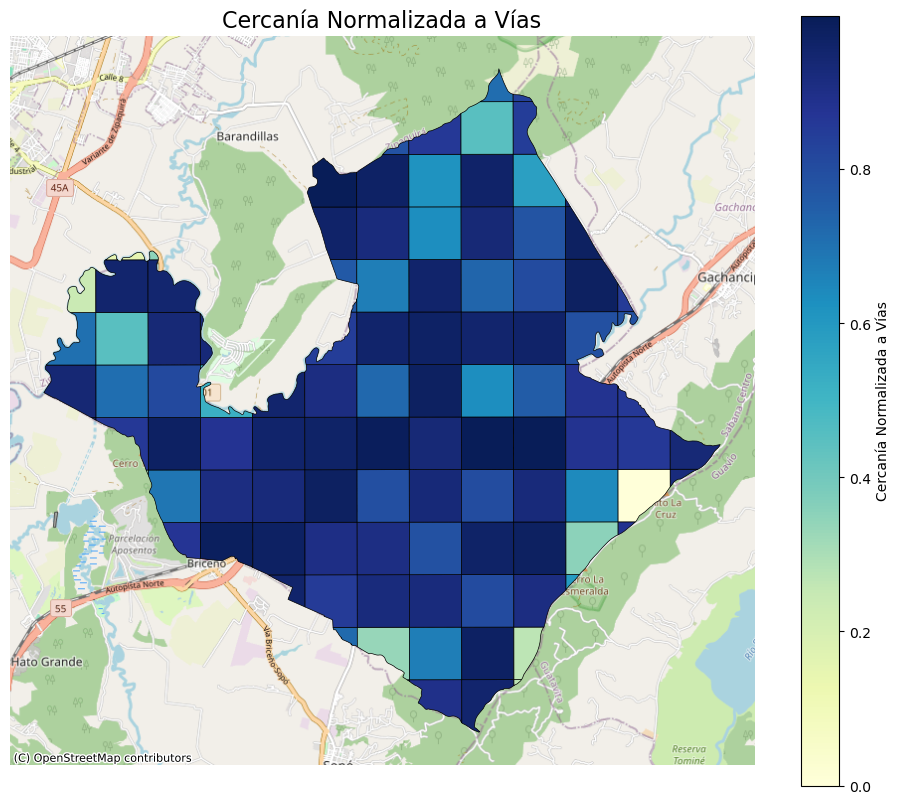

In [17]:
# Reproyectar para mapa base
grid_webmercator = grid.to_crs(epsg=3857)

ax = grid_webmercator.plot(
    column='cercania_vias_norm',
    cmap='YlGnBu',
    legend=True,
    legend_kwds={'label': "Cercanía Normalizada a Vías"},
    figsize=(12, 10),
    edgecolor='black',
    linewidth=0.5
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Cercanía Normalizada a Vías", fontsize=16)
ax.axis('off')
plt.show()

# Guardar el mapa generado 
fig = ax.get_figure()
fig.savefig(
    os.path.join(output_folder_maps, "Normalización_Cercania_vias_Normalizada.png"),
    dpi=300,
    bbox_inches='tight'
)

#### 2.4.1.8 Normalización de pendiente menor a 15°
* En el siguiente código se evalúa la aptitud de cada celda de una grilla según la pendiente del terreno, y genera un mapa que muestra si esa celda es apta o no para desarrollo urbano, con base en la condición: pendiente ≤ 15°. Además se visualizan las áreas aptas en verde y no aptas en rojo.

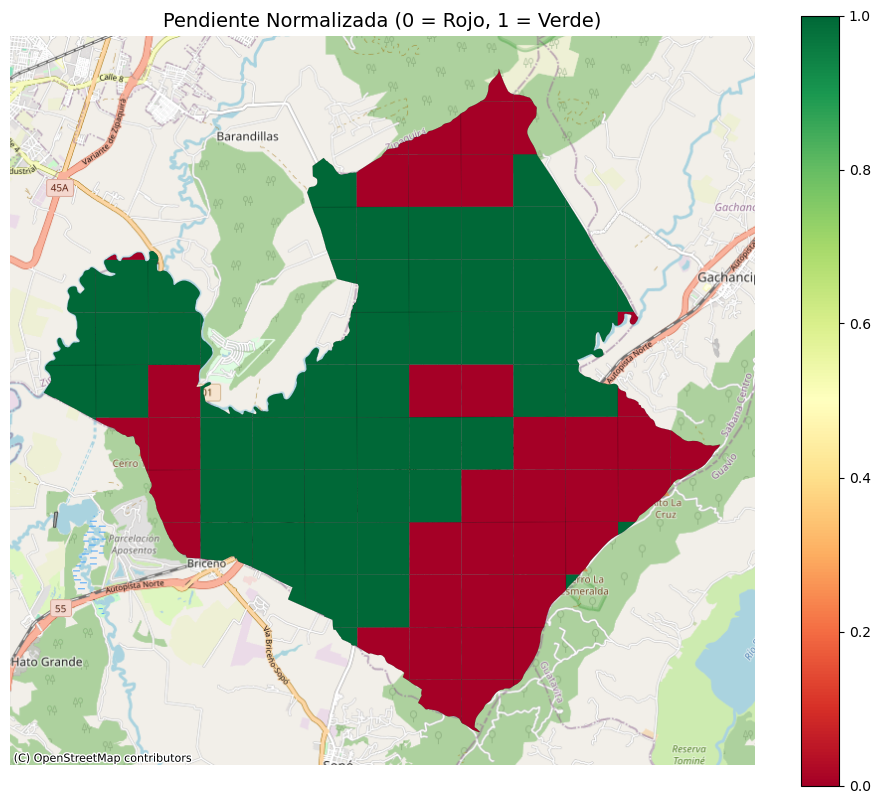

In [18]:
# Reproyectar para mapa base
grid = grid.to_crs(epsg=3857)
clas_pend = clas_pend.to_crs(epsg=3857)

# Crear columna 'pendiente_norm' en la grilla con valor inicial 0 (no apto)
grid['pendiente_norm'] = 0

# Para cada celda, si el centroide cae dentro de un polígono verde (pendiente ≤15°), asignar 1
# Generar centroides de cada celda
grid['centroide'] = grid.centroid

# Iterar por los polígonos verdes (pendiente_norm = 1)
poligonos_verdes = clas_pend[clas_pend['slope_class'] == 1]

# Función que evalúa si el punto cae dentro de algún polígono verde
def es_apto_pendiente(centroide):
    return poligonos_verdes.contains(centroide).any()

# Aplicar la función a cada centroide
grid['pendiente_norm'] = grid['centroide'].apply(es_apto_pendiente).astype(int)

# Visualizar
ax = grid.plot(
    column='pendiente_norm',
    cmap='RdYlGn',             # Este es el colormap que deseas
    legend=True,
    figsize=(12, 10),
    edgecolor='black',
    linewidth=0.1
)

ax.set_title('Pendiente Normalizada (0 = Rojo, 1 = Verde)', fontsize=14)
ax.axis('off')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()

# Guardar el mapa generado 
fig = ax.get_figure()
fig.savefig(
    os.path.join(output_folder_maps, "Normalización_Pendiente.png"),
    dpi=300,
    bbox_inches='tight'
)

#### 2.4.1.9 Normalización de cobertura agricola - Pastos
* El siguiente código identifica qué celdas de una grilla caen dentro de zonas cubiertas por pastos, y genera un mapa temático donde:
- 1 = celda con pasto (apta)
- 0 = celda sin pasto (no apta)

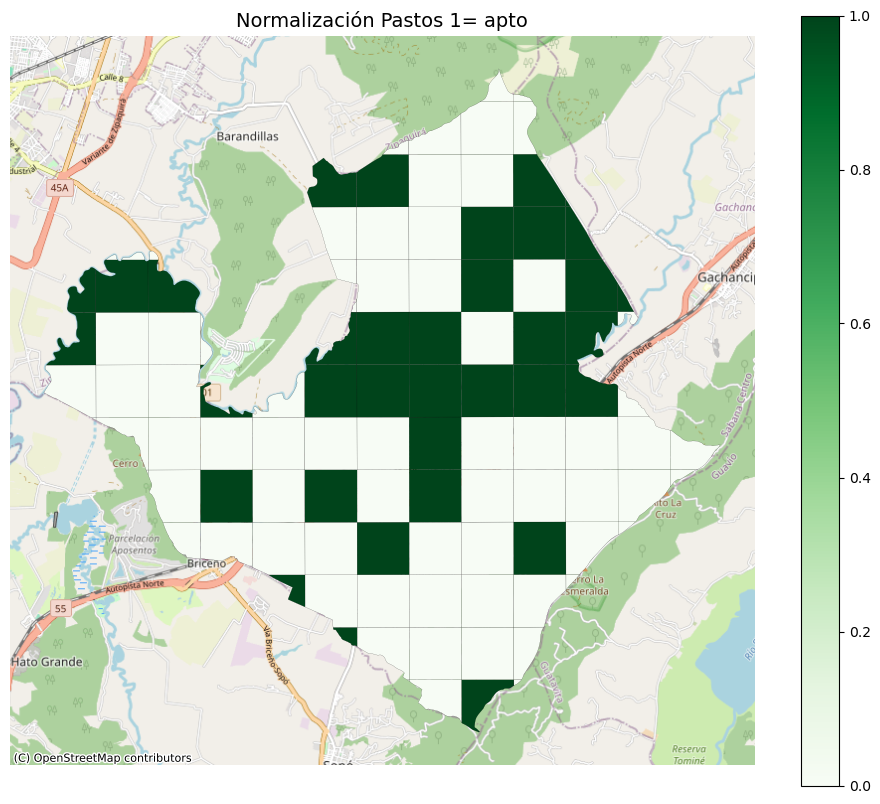

In [19]:
# Asegura que ambas capas estén en el mismo CRS
grid = grid.to_crs(epsg=3857)
Pastos = Pastos.to_crs(epsg=3857)

# Crear columna en la grilla con valor inicial 0 (no es pasto)
grid['pastos_norm'] = 0

# Generar centroides de las celdas
grid['centroide'] = grid.centroid

# Función para verificar si el centroide está dentro de algún polígono de pastos
def es_pasto(centroide):
    return Pastos.contains(centroide).any()

# Aplicar la función a cada celda (a cada centroide)
grid['pastos_norm'] = grid['centroide'].apply(es_pasto).astype(int)

# Visualización
ax = grid.plot(
    column='pastos_norm',
    cmap='Greens',            # Solo escala de verdes (0 = claro, 1 = verde fuerte)
    legend=True,
    figsize=(12, 10),
    edgecolor='black',
    linewidth=0.1
)

ax.set_title('Normalización Pastos 1= apto', fontsize=14)
ax.axis('off')

import contextily as ctx
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()

# Guardar el mapa generado 
fig = ax.get_figure()
fig.savefig(
    os.path.join(output_folder_maps, "Normalización_Pastos.png"),
    dpi=300,
    bbox_inches='tight'
)

## 2.5 ÍNDICE DE IDONEIDAD

### 2.5.1 Criterios y pesos sugeridos
**Justificación**                                                                                                                    

**Cercanía a vías principales**   0.25                La accesibilidad vial es prioritaria para el desarrollo urbano e industrial, favoreciendo conectividad y costos logísticos.          

**Cercanía a centros poblados**   0.20                La proximidad al núcleo urbano favorece la continuidad urbana, optimiza servicios y reduce costos de extensión de infraestructura.   

**Densidad vial**                 0.20                Una red vial densa permite expansión ordenada y accesible

**Pendiente menor a 15°**         0.20                Restricciones técnicas de aptitud física del suelo. El POT establece limitación a pendientes mayores a 15° para expansión urbana.    

**Cobertura agrícola (pastos)**   0.15                Preferencia por áreas agrícolas no especializadas (pastos). El POT restringe expansión sobre suelos agrícolas de alta productividad.
* Datos importantes: La Ley 388 de 1997 y el Decreto 1077 establecen criterios de accesibilidad y aptitud física como determinantes para la expansión. El POT prioriza expansión continua desde el centro urbano, condicionada por pendientes y accesibilidad vial. Las áreas agrícolas de baja productividad (como pastos) son las preferidas para expansión según la clasificación de suelos del POT.


* En el siguiente código se le asigna los pesos a cada criterio

In [20]:
# Crear índice de idoneidad mediante suma ponderada
grid['indice_idoneidad'] = (
    grid['cercania_vias_norm'] * 0.25 +   # Cercanía a vías (25%)
    grid['distancia_centro_norm'] * 0.20 +  # Proximidad al centro urbano (20%)
    grid['densidad_norm'] * 0.20 +        # Densidad urbana (20%)
    grid['pendiente_norm'] * 0.20 +       # Aptitud según pendiente (20%)
    grid['pastos_norm'] * 0.15            # Preferencia por áreas de pastos (15%)
)

* Visualización índice final

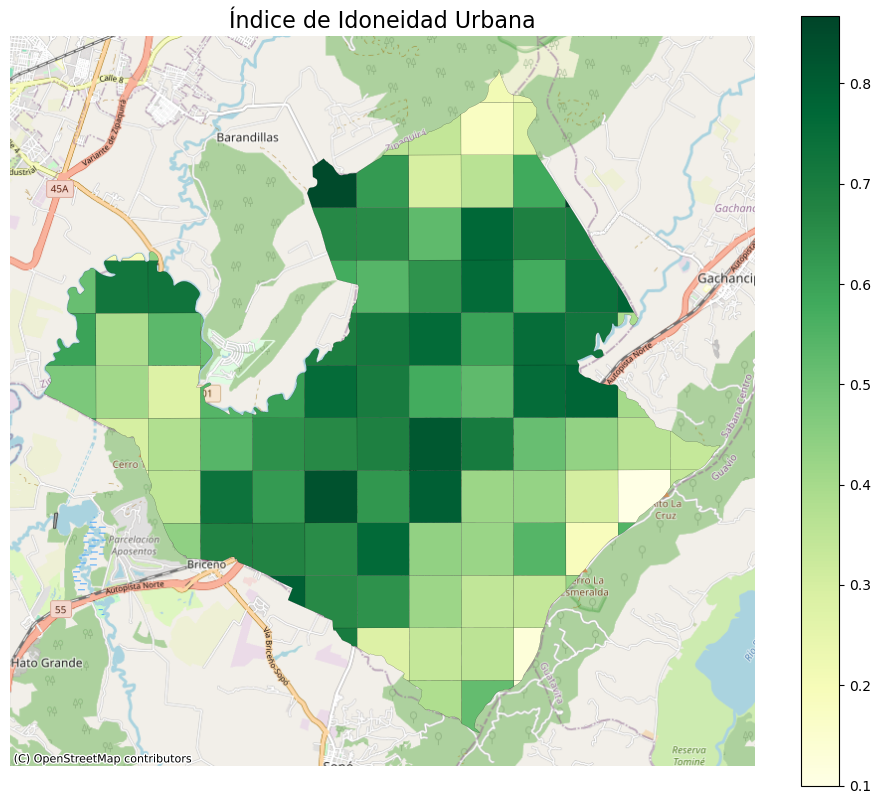

In [21]:
# Visualizar el índice final
ax = grid.plot(
    column='indice_idoneidad',
    cmap='YlGn',           
    legend=True,
    figsize=(12, 10),
    edgecolor='black',
    linewidth=0.1
)

ax.set_title('Índice de Idoneidad Urbana', fontsize=16)
ax.axis('off')

import contextily as ctx
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()

# Guardar el mapa generado 
fig = ax.get_figure()
fig.savefig(
    os.path.join(output_folder_maps, "Indice_idoneidad_Urbana.png"),
    dpi=300,
    bbox_inches='tight'
)

#### 2.5.1.1 Conclusión inicial

Según el mapa del índice de idoneidad urbana evidencia como resultado:

-Las zonas más oscuras (verde fuerte) son las más aptas para la expansión urbana.
-Las zonas más claras (verde claro o casi amarillo) son las menos aptas.
-Valores cercanos a 1 = muy aptos.
-Valores cercanos a 0 = poco aptos.


#### 2.5.1.2 Clasificación índice de idoneidad

Para cuantificar de forma clara cuánta área es apta para expansión urbana, se realiza una clasificación del índice de idoneidad en tres clases que permiten identificar de manera práctica las zonas con mayor, mediana y baja idoneidad. Esto facilita expresar resultados en porcentajes, analizar cuánta área realmente serviría para expansión, cuánta sería de idoneidad intermedia y cuánta área no resultaría funcional para este propósito.

Las clases definidas son:

**Alta (0.9 - 1):** áreas con alta idoneidad para expansión urbana.

**Media (0.6 - 0.8):** áreas con idoneidad intermedia.

**Baja (0 - 0.5):** áreas con baja idoneidad o no aptas para expansión urbana.

En el siguiente bloque de código, se crea esta clasificación para las celdas de la grilla a partir del índice de idoneidad calculado previamente.

In [22]:
# Crear clasificación de idoneidad
grid['idoneidad_clase'] = pd.cut(
    grid['indice_idoneidad'],
    bins=[0, 0.5, 0.8, 1],                  # AQUI definimos los rangos.... preguntarle a gis si estre tres o asi 
    labels=['Bajo', 'Medio', 'Alto'],         # Asigna etiquetas
    include_lowest=True
)
# Asignar valores numéricos a las clases (NECESARIO antes de graficar)
grid['idoneidad_clase_num'] = grid['idoneidad_clase'].map({
    'Bajo': 0,
    'Medio': 1,
    'Alto': 2
})
# Definir el cmap personalizado (TONOS PASTEL)
colores = ['#ff9999', '#ffcc99', '#99cc99']  # Rojo pastel, naranja pastel, verde pastel
cmap_personalizado = ListedColormap(colores)

* Calculo del porcentaje de cada clase:

In [23]:
# Contar celdas por clase
conteo = grid['idoneidad_clase'].value_counts(normalize=True) * 100

# Crear etiquetas con porcentaje
etiquetas_leyenda = {
    'Bajo': f'Bajo ({conteo.get("Bajo", 0):.1f}%)',
    'Medio': f'Medio ({conteo.get("Medio", 0):.1f}%)',
    'Alto': f'Alto ({conteo.get("Alto", 0):.1f}%)'
}

* Visualización

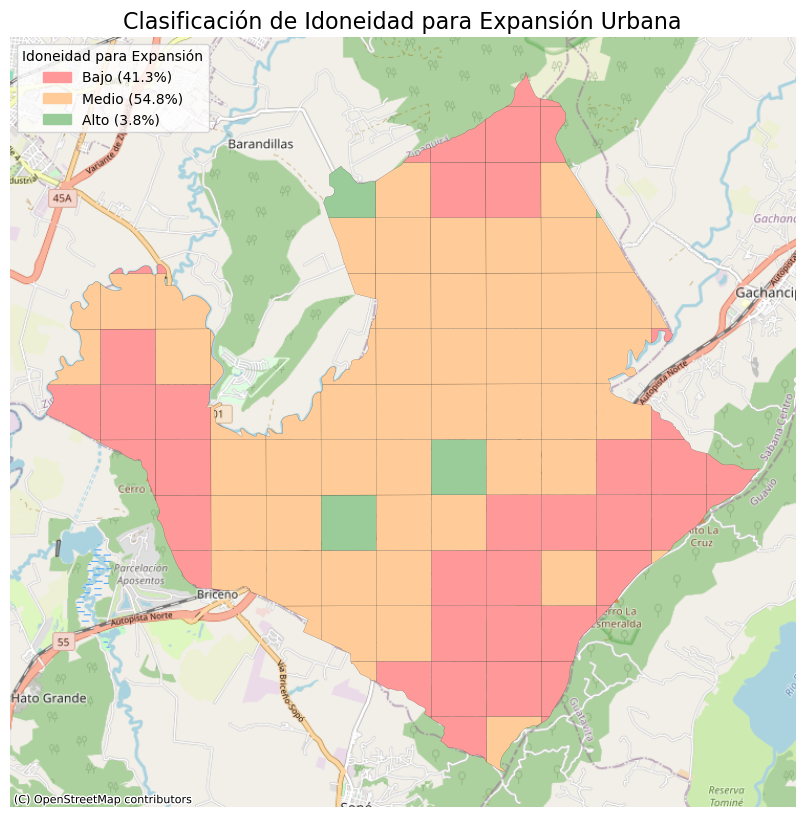

In [24]:
# Graficar
ax = grid.plot(
    column='idoneidad_clase_num',
    cmap=cmap_personalizado,
    figsize=(12, 10),
    edgecolor='black',
    linewidth=0.1
)

# Crear leyenda personalizada
leyenda_patches = [
    mpatches.Patch(color='#ff9999', label=etiquetas_leyenda['Bajo']),
    mpatches.Patch(color='#ffcc99', label=etiquetas_leyenda['Medio']),
    mpatches.Patch(color='#99cc99', label=etiquetas_leyenda['Alto'])
]

ax.legend(handles=leyenda_patches, title='Idoneidad para Expansión', loc='upper left')

# Opcionales
ax.set_title('Clasificación de Idoneidad para Expansión Urbana', fontsize=16)
ax.axis('off')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()

# Guardar el mapa generado 
fig = ax.get_figure()
fig.savefig(
    os.path.join(output_folder_maps, "Clasificacion_idoneidad_Expansión.png"),
    dpi=300,
    bbox_inches='tight'
)

In [28]:
# Crear columna con nombre corto para exportar (por límite de 10 caracteres del .shp)
grid['clase_txt'] = grid['idoneidad_clase']

# Eliminar geometría extra si existe
if 'centroide' in grid.columns:
    grid = grid.drop(columns=['centroide'])

# Establecer geometría activa
grid = grid.set_geometry("geometry")

# Crear carpeta de resultados si no existe
import os
os.makedirs("results", exist_ok=True)

# Exportar como shapefile (formato compatible con QGIS, GeoPandas, etc.)
grid.to_file("results/idoneidad_expansion.shp")

# Alternativa más moderna y robusta (recomendado si no necesitas .shp)
# grid.to_file("results/idoneidad_expansion.gpkg", driver="GPKG")

print(" Shapefile exportado correctamente a 'results/idoneidad_expansion.shp'")

 Shapefile exportado correctamente a 'results/idoneidad_expansion.shp'


/tmp/ipykernel_6421/1694664908.py:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  grid.to_file("results/idoneidad_expansion.shp")
/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'longitud_vias' to 'longitud_v'
  ogr_write(
/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'densidad_vial' to 'densidad_v'
  ogr_write(
/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'densidad_norm' to 'densidad_n'
  ogr_write(
/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'distancia_centro_poblado' to 'distancia_'
  ogr_write(
/opt/miniconda/lib/python3.11/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'distancia_centro_norm' to 'distanci_1'
  ogr_write(
/op